In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy
import astropy.table as atpy
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Column

import sherpa
import sherpa.ui as ui

import scipy
import scipy.integrate
import scipy.optimize as op

import logging

import time

import emcee
import corner


#add in all needed modules for things here...

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
%matplotlib inline

In [3]:
#avoid sherpa suppression of traceback
import sys
sys.tracebacklimit = 100

In [4]:
#default parameters and unit conversion factors
import defaultparams.params as params
import defaultparams.uconv as uconv

#functions to read data into format used by module
from massmod.set_prof_data import set_ne, set_tspec, set_meta

#functions to fit the gas density profile
from massmod.fit_density import fitne, find_nemodeltype

#functions to determine mass profile through backwards modelling
from massmod.fit_temperature import fit_ml, fit_mcmc

#functions to analyze the marginalized posterior distribution
from massmod.posterior_mcmc import calc_posterior_mcmc, samples_results

#plotting functions
from massmod.plotting import plt_mcmc_freeparam, plt_summary, plt_summary_nice

#functions specifically to generate mock data from Vikhlinin+ profiles
from exampledata.vikhlinin_prof import vikhlinin_tprof, vikhlinin_neprof, gen_mock_data

# Goal:
The primary goal of this example script is to showcase the tools available in the bmpmod package using mock data. The mock data is produced by randomly sampling the density and temperature profiles models published in Vikhlinin+06 for a sample of clusters (Vikhlinin, A., et al. 2006, ApJ, 640, 691). A secondary goal of this example is thus to also explore how the backwards mass modeling process used in the bmpmod package compares to the forward fitting results of Vikhlinin+. 

The mock profiles generated here allow for a flexible choice in noise and radial sampling rate, which enables an exploration of how these quantities affect the output of the backwards-fitting process. There is also some flexibility built into the bmpmod package that can be additionally tested here such as allowing for the stellar mass of the central galaxy to be included (or not included) in the model of total gravitating mass. If the stellar mass profile of the BCG is toggled on, the values for the BCG effective radius Re are pulled from the 2MASS catalog values for a de Vaucouleurs fit to their K-band data .
    
After generating the mock temperature and density profiles, the below code walks the user through performing the backwards-fitting mass modelling analysis which can be summarized as fitting the below $T_{\mathrm{model}}$ expression to the observed temperature profile by constraining the parameters in the total gravitating mass model $M_{\mathrm{tot}}$:

$kT_{\mathrm{model}}(R) = \frac{kT(R_{\mathrm{ref}}) \ n_{e}(R_{\mathrm{ref}})}{n_{e}(R)} -\frac{\mu m_{p} G}{n_{e}(R)}
\int_{R_{\mathrm{ref}}}^R \frac{n_{e}(r) M_{\mathrm{grav}}(r)}{r^2} dr$

The output of the bmpmod analysis includes a non-parametric model fit to the temperature profile, the total mass profile and its associated parameters describing the profile (e.g., the NFW c, Rs), and the contributions of different mass components (i.e., DM, gas, stars) to the total mass profile.


This tutorial will go over:  
1. Generating mock gas density and temperature data
2. Fiting the gas density profile with a parametric model
3. Maximum likelihood mass profile parameter estimation 
4. MCMC mass profile parameter estimation
5. Plotting and summarizing the results


### A note on usage:
Any of the clusters in Vikhlinin+06 are options to be used to generate randomly sampled temperature and density profiles. The full list of clusters is as follows:
    
Vikhlinin+ clusters: [A133, A262, A383, A478, A907, A1413, A1795, A1991, A2029, A2390, RXJ1159+5531, MKW4, USGCS152] 
 
After selecting one of these clusters, this example script will automatically generate the cluster and profile data in the proper format to be used by the bmpmod modules. If you have your own data you would like to analyze with the bmpmod package, please see the included template.py file.
    

In [5]:
#select any cluster ID from the Vikhlinin+ paper
clusterID='A383'

# 1. Generate mock gas density and temperature profiles 

To generate the mock profiles, the density and temperature models define in Table 2 and 3 of Vikhlinin+06 are sampled.  

The sampling of the models occurs in equally log-spaced radial bins with the number of bins set by N_ne and N_temp in gen_mock_data(). At each radial point, the density and temperature values are randomly sampled from a Gaussian distribution centered on the model value and with standard deviation equal to noise_ne and noise_temp multiplied by the model value for density or temperature.

Args for gen_mock_data():  
N_ne: the number of gas density profile data points  
N_temp: the number of temperature profile data points
noise_ne: the percent noise on the density values  
noise_temp: the percent noise on the temperature values 
refindex: index into profile where Tmodel = Tspec
incl_mstar: include stellar mass of the central galaxy in the model for total gravitating mass  
incl_mgas: include gas mass of ICM in the model for total gravitating mass  

In [6]:
clustermeta, ne_data, tspec_data, nemodel_vikh, tmodel_vikh \
    = gen_mock_data(clusterID=clusterID, 
                   N_ne=25,  
                   N_temp=12,  
                   noise_ne=0.15, 
                   noise_temp=0.05, 
                   refindex=-1,
                   incl_mstar=1, 
                   incl_mgas=1) 


Now let's take a look at the returns... while these are generated automatically here, if you use your own data, things should be in a similar form.

In [7]:
# clustermeta: 
# dictionary that stores relevant properties of cluster 
#     (i.e., name, redshift, bcg_re: the effective radius of the central galaxy in kpc, 
#      bcg_sersc_n: the sersic index of the central galaxy)
# as well as selections for analysis 
#     (i.e., incl_mstar, incl_mgas, refindex as input previously)

clustermeta

{'bcg_re': 18.03,
 'bcg_sersic_n': 4.0,
 'incl_mgas': 1,
 'incl_mstar': 1,
 'name': 'A383',
 'refindex': -1,
 'z': 0.1883}

In [8]:
#ne_data: dictionary that stores the mock "observed" gas density profile  

ne_data[:3]

radius,ne,ne_err,radius_lowerbound,radius_upperbound
float64,float64,float64,float64,float64
25.000000000000007,0.033706794012741154,0.005208529808995391,3.552713678800501e-15,1.9419087109034159
28.88381742180684,0.040034308459837874,0.004478264729147212,1.9419087109034159,2.243589466222012
33.37099635425086,0.026163871551539746,0.003843537171832415,2.243589466222012,2.5921371404738345


In [9]:
#tspec_data: dictionary that store the mock "observed" temperature profile  
tspec_data[:3]

radius,tspec,tspec_err,tspec_lowerbound,tspec_upperbound,radius_lowerbound,radius_upperbound
float64,float64,float64,float64,float64,float64,float64
25.000000000000007,3.192918127273867,0.16731220167471209,0.16731220167471209,0.16731220167471209,3.552713678800501e-15,4.629387309001547
34.2587746180031,3.477063341540646,0.1745463717697194,0.1745463717697194,0.1745463717697194,4.629387309001547,6.343885457541116
46.946545533085335,3.6042262114010977,0.18322656734344922,0.18322656734344922,0.18322656734344922,6.343885457541116,8.693349683693125


Let's take a look at how our mock profiles compare to the model we're sampling from ...

Text(0,0.5,u'kT [keV]')

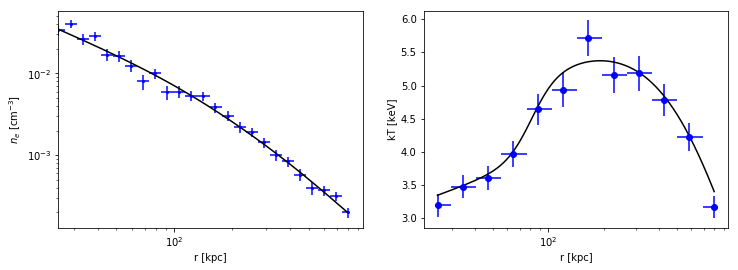

In [10]:
fig1 = plt.figure(1, (12, 4))
ax = fig1.add_subplot(1, 2, 1)


'''
mock gas denisty profile
'''

# plot Vikhlinin+06 density model
xplot = np.logspace(np.log10(min(ne_data['radius'])), np.log10(max(ne_data['radius'])), 1000)
plt.loglog(xplot, vikhlinin_neprof(nemodel_vikh, xplot), 'k')
plt.xlim(xmin=min(ne_data['radius']))

# plot sampled density data
plt.errorbar(ne_data['radius'], ne_data['ne'],
             xerr=[ne_data['radius_lowerbound'], ne_data['radius_upperbound']],
             yerr=ne_data['ne_err'], marker='o', markersize=2, linestyle='none', color='b')

ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

plt.xlabel('r [kpc]')
plt.ylabel('$n_{e}$ [cm$^{-3}$]')


'''
mock temperature profile
'''
ax = fig1.add_subplot(1, 2, 2)

# plot Vikhlinin+06 temperature model
xplot = np.logspace(np.log10(min(tspec_data['radius'])), np.log10(max(tspec_data['radius'])), 1000)
plt.semilogx(xplot, vikhlinin_tprof(tmodel_vikh, xplot), 'k-')

# plot sampled temperature data
plt.errorbar(tspec_data['radius'], tspec_data['tspec'],
             xerr=[tspec_data['radius_lowerbound'], tspec_data['radius_upperbound']],
             yerr=[tspec_data['tspec_lowerbound'], tspec_data['tspec_upperbound']],
             marker='o', linestyle='none', color='b')

plt.xlabel('r [kpc]')
plt.ylabel('kT [keV]')

# 2. Fitting the gas density profile with a parametric model

To determine the best-fitting gas density model, bmpmod has the option of fitting the four following $n_{e}$ models through the Levenberg-Marquart optimization method. 

"single\_beta":  
$n_{e} = n_{e,0} \ (1+(r/r_{c})^{2})^{-\frac{3}{2}\beta}$

"cusped\_beta":  
$n_{e} = n_{e,0} \ (r/r_{c})^{-\alpha} \ (1+(r/r_{c})^{2})^{-\frac{3}{2}\beta+\frac{1}{2}\alpha}$

"double\_beta\_tied":  
$n_{e} = n_{e,1}(n_{e,0,1}, r_{c,1}, \beta)+n_{e,2}(n_{e,0,2}, r_{c,2}, \beta)$

"double\_beta":  
$n_{e} = n_{e,1}(n_{e,0,1}, r_{c,1}, \beta_1)+n_{e,2}(n_{e,0,2}, r_{c,2}, \beta_2)$

All four models can be fit and compared using the find_nemodeltype() function. A selected model must then be chosen for the following mass profile analysis with the fitne() function.

massmod/density_models.py:71: RuntimeWarning: divide by zero encountered in power
  * ((1.+((x/rc)**2.))**((-3.*beta/2.)+(alpha/2.)))  # [cm^-3]


model with lowest reduced chi-squared: double_beta_tied


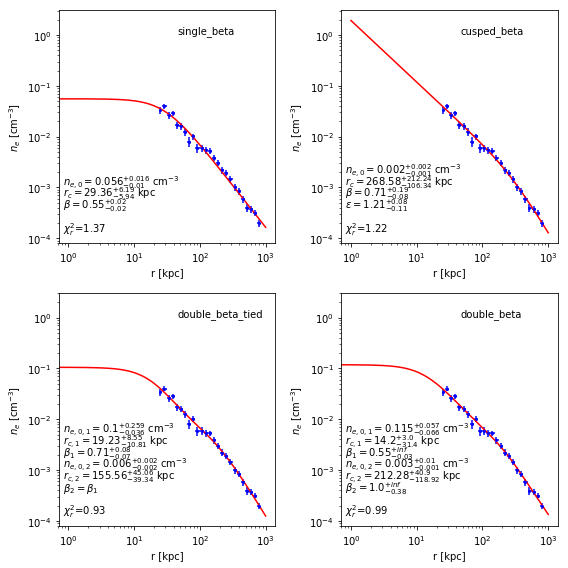

In [11]:
#suppress verbose log info from sherpa
logger = logging.getLogger("sherpa")
logger.setLevel(logging.ERROR)

#fit all four ne moels and return the model with the lowest reduced chi-squared as nemodeltype
nemodeltype, fig=find_nemodeltype(ne_data=ne_data, 
                                  tspec_data=tspec_data, 
                                  optplt=1)
print 'model with lowest reduced chi-squared:', nemodeltype

*Note*: while the function find_nemodeltype() returns the model type producing the lowest reduced chi-squared fit, it may be better to choose a simpler model with fewer free-parameters if the reduced chi-squared values are similar

In [12]:
# Turn on logging for sherpa to see details of fit
logger = logging.getLogger("sherpa")
logger.setLevel(logging.INFO)

# Find the parameters and errors of the seleted gas density model
nemodel=fitne(ne_data=ne_data,tspec_data=tspec_data,nemodeltype=str(nemodeltype)) #[cm^-3]

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 900.559
Final fit statistic   = 18.5498 at function evaluation 101
Data points           = 25
Degrees of freedom    = 20
Probability [Q-value] = 0.551239
Reduced statistic     = 0.927489
Change in statistic   = 882.009
   doublebeta1d_tied.ne01   0.0995291   
   doublebeta1d_tied.rc1   19.2295     
   doublebeta1d_tied.beta1   0.712114    
   doublebeta1d_tied.ne02   0.00564984  
   doublebeta1d_tied.rc2   155.562     
doublebeta1d_tied.rc2 lower bound:	-39.336
doublebeta1d_tied.ne01 lower bound:	-0.0359246
doublebeta1d_tied.ne02 lower bound:	-0.00161311
doublebeta1d_tied.rc2 upper bound:	45.0646
doublebeta1d_tied.ne01 upper bound:	0.258588
doublebeta1d_tied.beta1 lower bound:	-0.065647
doublebeta1d_tied.rc1 lower bound:	-10.8059
doublebeta1d_tied.beta1 upper bound:	0.0824153
doublebeta1d_tied.rc1 upper bound:	8.54598
doublebeta1d_tied.ne02 upper bound:	0.00227564
Dataset      

In [13]:
#nemodel stores all the useful information from the fit to the gas denisty profile
print nemodel.keys()

['parmins', 'nefit', 'dof', 'parmaxes', 'rchisq', 'chisq', 'parvals', 'parnames', 'type']


# 3. Maximum likelihood estimation of mass profile free-parameters

The maximum likelihood method can be used to perform an initial estimation of the free-parameters in the cluster mass profile model. 

The free parameters in the mass model, which will be returned in this estimation, are:
- the mass concentration $c$ of the NFW profile used to model the DM halo, 
- the scale radius $R_s$ of the NFW profile
- optionally, the log of the normalization of the Sersic model $\rho_{\star,0}$ used to model the stellar mass profile of the central galaxy

The maximum likelihood estimation is performed using a Gaussian log-likelihood function of the form:
$\ln(p) = -\frac{1}{2} \sum_{n} \left[\frac{(T_{\mathrm{spec},n} - T_{\mathrm{model},n})^{2}}{\sigma_{T_{\mathrm{spec},n}}^{2}} + \ln (2 \pi \sigma_{T_{\mathrm{spec},n}}^{2}) \right]$


In [14]:
ml_results = fit_ml(ne_data, tspec_data, nemodel, clustermeta)

MLE results
MLE: c= 3.3140913560902994
MLE: rs= 310.76185584194434
MLE: normsersic= 8.053052982368904


bmpmod uses these maximum likelihood results to initialize the walkers in the MCMC chain...

# 4. MCMC estimation of mass profile model parameters

Here the emcee python package is implemented to estimate the free-parameters of the mass model through the MCMC algorithm. bmpmod utilizes the ensemble sampler from emcee, and initializes the walkers in narrow Gaussian distribution about the parameter values returned from the maximum likelihood analysis.

Returns of fit_mcmc():  
samples - the marginalized posterior distribution  
sampler - the sampler class output by emcee  

In [15]:
#fit for the mass model and temperature profile model through MCMC
samples, sampler = fit_mcmc(ne_data=ne_data, 
                            tspec_data=tspec_data, 
                            nemodel=nemodel, 
                            ml_results=ml_results, 
                            clustermeta=clustermeta,
                            Ncores=3,
                            Nwalkers=50,
                            Nsteps=50,
                            Nburnin=10)

MCMC progress: 10.0%
MCMC progress: 20.0%
MCMC progress: 30.0%
MCMC progress: 40.0%
MCMC progress: 50.0%
MCMC progress: 60.0%
MCMC progress: 70.0%
MCMC progress: 80.0%
MCMC progress: 90.0%
MCMC progress: 100.0%
autocorrelation time: autocorrelation time cannot be calculated



*Note*: autocorrelation time should be longer than Nburnin

#### 4.1 analysis of the marginalized MCMC distribution

We also want to calculate the radius of the cluster $R_{500}$  and the mass (total, DM, gas, stars) within this radius. The auxililary calculations are taken care of in samples_aux() for each step of the MCMC chain.

In [16]:
# calculate R500 and M(R500) for each step of MCMC chain
samples_aux = calc_posterior_mcmc(samples=samples, 
                                  nemodel=nemodel, 
                                  clustermeta=clustermeta,
                                  Ncores=1)

From the marginialized MCMC distribution, we can calculate the free-parameter and auxiliary parameter (R500, M500) values as the median of the distribution with confidence intervals defined by the 16th and 84th percentiles. 

With samples_results() we combine all output parameter values and their upper and lower 1$\sigma$ error bounds.

In [17]:
# combine all MCMC results
mcmc_results = samples_results(samples=samples,
                             samples_aux=samples_aux,
                             clustermeta=clustermeta)

for key in mcmc_results.keys():
    print 'MCMC: '+str(key)+' = '+str(mcmc_results[str(key)])

MCMC: c = (3.3141773153437333, 0.03267208471308569, 0.02797853603445244)
MCMC: mdelta = (433675299519681.25, 11346413279925.812, 14066964308327.75)
MCMC: rdelta = (1082.0, 9.159999999999854, 12.0)
MCMC: mdm = (390095335790485.1, 10946618533893.188, 13542681641715.625)
MCMC: rs = (310.75734735578044, 1.9431311446622885, 2.7082409023124683)
MCMC: mgas = (43579949456068.88, 399807133649.40625, 524279619550.3203)
MCMC: normsersic = (8.050849170250498, 0.6201850487311908, 1.2124952072490105)
MCMC: mstars = (14175339.41572019, 44944351.366173, 13306300.242661903)


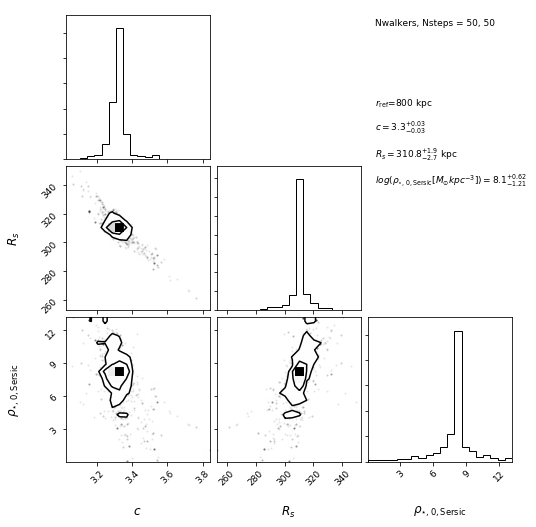

In [18]:
#Corner plot of marginalized posterior distribution of free params from MCMC
fig1 = plt_mcmc_freeparam(mcmc_results=mcmc_results, 
                          samples=samples, 
                          sampler=sampler, 
                          tspec_data=tspec_data, 
                          clustermeta=clustermeta)

# 5. Summary plot

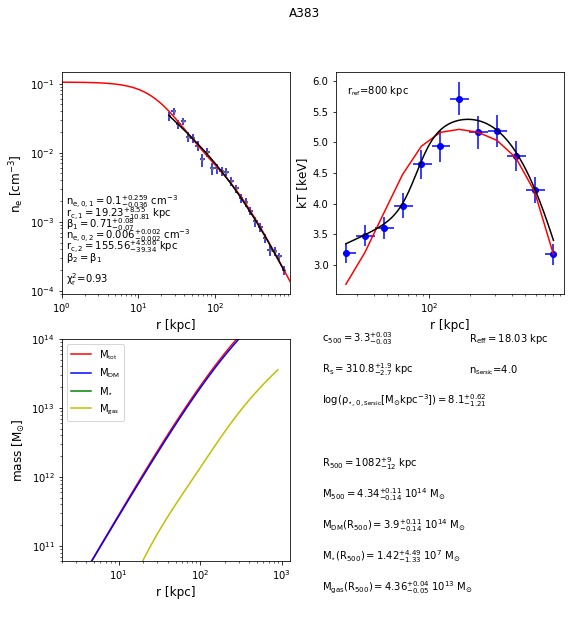

In [19]:
# Summary plot: density profile, temperature profile, mass profile
fig2, ax1, ax2 = plt_summary(ne_data=ne_data,
                             tspec_data=tspec_data,
                             nemodel=nemodel,
                             mcmc_results=mcmc_results,
                             clustermeta=clustermeta)

# add vikhlinin model to density plot
xplot = np.logspace(np.log10(min(ne_data['radius'])), np.log10(max(ne_data['radius'])), 1000)
ax1.plot(xplot, vikhlinin_neprof(nemodel_vikh, xplot), 'k')
#plt.xlim(xmin=min(ne_data['radius']))

# add viklinin model to temperature plot
xplot = np.logspace(np.log10(min(tspec_data['radius'])), np.log10(max(tspec_data['radius'])), 1000)
ax2.plot(xplot, vikhlinin_tprof(tmodel_vikh, xplot), 'k-')